In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load your dataset
data = pd.read_csv('s3://mynewreviews/updated_Reviews.csv')



In [6]:
# Get the number of rows and columns
print("Number of rows:", data.shape[0])  # Number of rows
print("Number of columns:", data.shape[1])  # Number of columns


Number of rows: 500
Number of columns: 10


In [7]:
# Get memory usage
print("Memory usage of the dataset:", data.memory_usage(deep=True).sum(), "bytes")


Memory usage of the dataset: 258093 bytes


In [8]:
# Get detailed info about the dataset
data.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      500 non-null    int64  
 1   productid               500 non-null    object 
 2   userid                  500 non-null    object 
 3   profilename             500 non-null    object 
 4   helpfulnessnumerator    498 non-null    float64
 5   helpfulnessdenominator  500 non-null    int64  
 6   score                   500 non-null    int64  
 7   time                    500 non-null    int64  
 8   summary                 500 non-null    object 
 9   text                    500 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 252.0 KB


In [9]:
# Check the data types of the columns
print(data.dtypes)

# Display rows where non-numeric data might exist
print(data.select_dtypes(include=['object']).head())


id                          int64
productid                  object
userid                     object
profilename                object
helpfulnessnumerator      float64
helpfulnessdenominator      int64
score                       int64
time                        int64
summary                    object
text                       object
dtype: object
    productid          userid                   profilename  \
0  B000UA0QIQ  A395BORC6FGVXV                          Karl   
1  B0000CES0O  A2J0EIL4HFJ4PP                 Landscape guy   
2  B0000CAV3Y   A5HVN6DW5S9DF  "L. J. Pizzuto ""Ladygrey"""   
3  B0025U8ILG  A1GYEGLX3P2Y7P                Shala Kerrigan   
4  B001GVISJM  A3KLWF6WQ5BNYO                Erica Neathery   

                                             summary  \
0                                     Cough Medicine   
1                                          Very good   
2                        Natasha's cafe coffee beans   
3  Can't beat this for convenience if you h

In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import boto3
import joblib
import sagemaker
from sagemaker.sklearn import SKLearnModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer  # New import for handling missing values

# Step 1: Load the dataset
data = pd.read_csv('s3://mynewreviews/updated_Reviews.csv')

# Step 2: Data Preprocessing
# Label encode 'productid', 'userid', and 'profilename'
label_encoder = LabelEncoder()
data['productid'] = label_encoder.fit_transform(data['productid'])
data['userid'] = label_encoder.fit_transform(data['userid'])
data['profilename'] = label_encoder.fit_transform(data['profilename'])
print(data.head())


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
       id  productid  userid  profilename  helpfulnessnumerator  \
0       4         47     291          299                   3.0   
1  126325          2     208          309                   2.0   
2  126338          1     388           67                   0.0   
3  126342        112      55          399                   0.0   
4      17         89     333          233                   0.0   

   helpfulnessdenominator  score        time  \
0                       3      2  1307923200   
1                       2      4  1337558400   
2                       0      4  1174608000   
3                       0      4  1273622400   
4                       0      2  1348099200   

                                             summary  \
0                                     Cough Me

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [12]:


# Convert 'score' to numeric and ensure it's encoded from 0
score_encoder = LabelEncoder()
data['score'] = score_encoder.fit_transform(data['score'])  # This will shift class labels to [0, 1, 2, 3, 4]
print(data.head())



       id  productid  userid  profilename  helpfulnessnumerator  \
0       4         47     291          299                   3.0   
1  126325          2     208          309                   2.0   
2  126338          1     388           67                   0.0   
3  126342        112      55          399                   0.0   
4      17         89     333          233                   0.0   

   helpfulnessdenominator  score        time  \
0                       3      1  1307923200   
1                       2      3  1337558400   
2                       0      3  1174608000   
3                       0      3  1273622400   
4                       0      1  1348099200   

                                             summary  \
0                                     Cough Medicine   
1                                          Very good   
2                        Natasha's cafe coffee beans   
3  Can't beat this for convenience if you have teens   
4                           

In [13]:

# Combine the text columns into a single text feature
data['combined_text'] = data['summary'] + " " + data['text']

# Apply TF-IDF Vectorization to the combined text
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = tfidf.fit_transform(data['combined_text'])
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
# Convert sparse matrix to dense matrix
X_text_dense = X_text.toarray()
print(X_text_dense.shape)



(500, 1000)


In [14]:

# Combine TF-IDF features with other numerical features
X_numerical = np.hstack([data.drop(columns=['score', 'summary', 'text', 'combined_text']).values, X_text_dense])

# Features (X) and target (y)
X = X_numerical
y = data['score']

# Step 3: Handle missing values (imputation)
# Using SimpleImputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



Training set size: (400, 1007)
Test set size: (100, 1007)


In [15]:

# Step 5: Initialize models for comparison
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(n_estimators=100)
}

# Step 6: Train and evaluate models
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {accuracy:.4f}")
    
    # Classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification report for {model_name}:\n{report}")
    
    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Step 7: Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')

#


Training Random Forest...
Accuracy of Random Forest: 0.9800
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        17
           2       0.95      0.95      0.95        20
           3       1.00      0.96      0.98        25
           4       0.96      1.00      0.98        24

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100


Training Logistic Regression...
Accuracy of Logistic Regression: 0.9900
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        25
           4      

['best_model.pkl']

Matplotlib is building the font cache; this may take a moment.


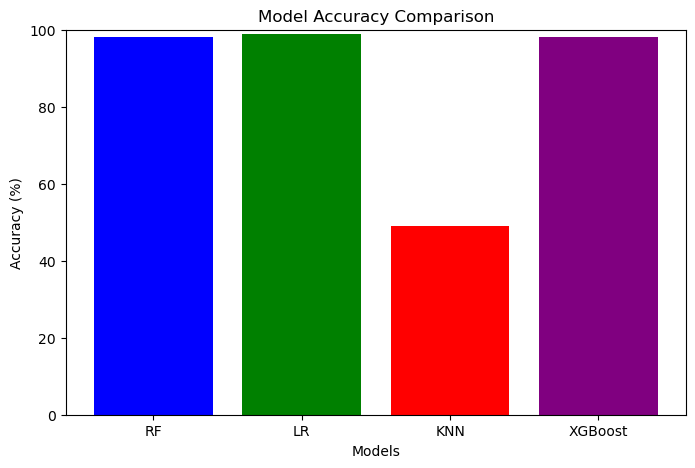

In [31]:
import matplotlib.pyplot as plt

# Data for the models
models = ['RF', 'LR', 'KNN', 'XGBoost']
accuracy = [98, 99, 49, 98]

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


In [16]:
 #Step 8: Upload the model to S3
bucket_name = 'mydeploy18'  # Updated to your S3 bucket
s3 = boto3.client('s3')

# Upload the model file to S3
s3.upload_file('best_model.pkl', bucket_name, 'models/best_model.pkl')

print("Model uploaded to S3 successfully.")


Model uploaded to S3 successfully.


In [17]:
import tarfile

# Path to the model file
model_file = 'best_model.pkl'
archive_name = 'best_model.tar.gz'

# Create the tar.gz archive
with tarfile.open(archive_name, "w:gz") as tar:
    tar.add(model_file, arcname=model_file)

print(f"Created archive: {archive_name}")
import boto3

# Define S3 bucket name and the path where you want to store the model
s3_bucket = 'mydeploy18'  # Replace with your actual S3 bucket name
s3_model_path = 'models/best_model.tar.gz'

# Initialize S3 client
s3_client = boto3.client('s3')

# Upload the model archive to S3
s3_client.upload_file(archive_name, s3_bucket, s3_model_path)

print(f"Model uploaded to s3://{s3_bucket}/{s3_model_path}")


Created archive: best_model.tar.gz
Model uploaded to s3://mydeploy18/models/best_model.tar.gz


DEPLOY MODEL

In [18]:
import sagemaker
from sagemaker.sklearn import SKLearnModel

# Define the S3 bucket name where the model is stored
mydeploy18 = "mydeploy18"  # Your actual S3 bucket name


# Define the IAM role for SageMaker
role = "arn:aws:iam::194722417457:role/service-role/AmazonSageMaker-ExecutionRole-20241020T181073" # Replace with your SageMaker IAM role ARN

# Create a SageMaker session
session = sagemaker.Session()

# Deploy the model using SKLearnModel with `ml.t2.medium` instance type (Free Tier eligible)
model = SKLearnModel(
    model_data = f"s3://{mydeploy18}/models/best_model.tar.gz",  # Correct path to the model
    role=role,
    entry_point="inference.py",  # The inference script you created
    framework_version="0.23-1"
)

# Deploy the model to an endpoint with Free Tier eligible instance type `ml.t2.medium`
predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

print(f"Model deployed to endpoint {predictor.endpoint_name}")



-----!Model deployed to endpoint sagemaker-scikit-learn-2024-11-20-12-57-37-100


In [24]:
import boto3

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List all endpoints
response = sagemaker_client.list_endpoints()

# Get the endpoint names
endpoints = response['Endpoints']

# Print the endpoint names
for endpoint in endpoints:
    print(f"Endpoint Name: {endpoint['EndpointName']}")


Endpoint Name: sagemaker-scikit-learn-2024-11-20-12-57-37-100


In [20]:
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List all models
models = sagemaker_client.list_models()
for model in models['Models']:
    print("Model Name:", model['ModelName'])

Model Name: sagemaker-scikit-learn-2024-11-20-12-57-36-519


In [25]:
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Get the endpoint configuration name from your endpoint description
endpoint_name = "sagemaker-scikit-learn-2024-11-20-12-57-37-100"# Your actual endpoint name
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)

# Get the endpoint configuration
endpoint_config_name = response['EndpointConfigName']

# Describe the endpoint configuration
config_response = sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)

# Print the entire configuration response to understand its structure
print(config_response)



{'EndpointConfigName': 'sagemaker-scikit-learn-2024-11-20-12-57-37-100', 'EndpointConfigArn': 'arn:aws:sagemaker:ap-southeast-2:194722417457:endpoint-config/sagemaker-scikit-learn-2024-11-20-12-57-37-100', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'ModelName': 'sagemaker-scikit-learn-2024-11-20-12-57-36-519', 'InitialInstanceCount': 1, 'InstanceType': 'ml.t2.medium', 'InitialVariantWeight': 1.0}], 'CreationTime': datetime.datetime(2024, 11, 20, 12, 57, 37, 290000, tzinfo=tzlocal()), 'EnableNetworkIsolation': False, 'ResponseMetadata': {'RequestId': '0d8bb1df-6c8c-4197-b1c0-3b3564e12613', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0d8bb1df-6c8c-4197-b1c0-3b3564e12613', 'content-type': 'application/x-amz-json-1.1', 'content-length': '459', 'date': 'Wed, 20 Nov 2024 13:05:45 GMT'}, 'RetryAttempts': 0}}


In [26]:
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Describe the endpoint
endpoint_name = "sagemaker-scikit-learn-2024-11-20-12-57-37-100"  # Replace with your endpoint name
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)

# Print the full response
print(response)


{'EndpointName': 'sagemaker-scikit-learn-2024-11-20-12-57-37-100', 'EndpointArn': 'arn:aws:sagemaker:ap-southeast-2:194722417457:endpoint/sagemaker-scikit-learn-2024-11-20-12-57-37-100', 'EndpointConfigName': 'sagemaker-scikit-learn-2024-11-20-12-57-37-100', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'DeployedImages': [{'SpecifiedImage': '783357654285.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3', 'ResolvedImage': '783357654285.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-scikit-learn@sha256:d85fcec01c69ba8646733a4ca54b851b40385c508d57f7eaf57c75c9d978ad7c', 'ResolutionTime': datetime.datetime(2024, 11, 20, 12, 57, 38, 116000, tzinfo=tzlocal())}], 'CurrentWeight': 1.0, 'DesiredWeight': 1.0, 'CurrentInstanceCount': 1, 'DesiredInstanceCount': 1}], 'EndpointStatus': 'InService', 'CreationTime': datetime.datetime(2024, 11, 20, 12, 57, 37, 647000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2024, 11, 20, 13, 0, 32, 338000, tzinfo=tzlocal

In [27]:
## To diplay errors from Cloudwatch logs
input_data = {
    'instances': X_test.tolist()  # Make sure this matches the format expected by the model
}
try:
    # Simulate prediction locally
    predictions = model.predict(np.array(input_data["instances"]))
    print(predictions)
except Exception as e:
    print(f"Error during prediction: {e}")


Error during prediction: 'dict' object has no attribute 'predict'


In [28]:
##To delete endpoint 
import boto3

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Define the endpoint name to delete
endpoint_name = "sagemaker-scikit-learn-2024-11-20-12-57-37-100"# Use the endpoint name you want to delete

# Delete the endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

print(f"Endpoint {endpoint_name} deleted successfully.")


Endpoint sagemaker-scikit-learn-2024-11-20-12-57-37-100 deleted successfully.


In [2]:
# To display the existing endpoints
import boto3

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List all endpoints
response = sagemaker_client.list_endpoints()

# Get the endpoint names
endpoints = response['Endpoints']

# Print the endpoint names
for endpoint in endpoints:
    print(f"Endpoint Name: {endpoint['EndpointName']}")


Endpoint Name: sagemaker-scikit-learn-2024-11-20-12-29-21-695


In [29]:
## To display all models present

import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List all models
models = sagemaker_client.list_models()
for model in models['Models']:
    print("Model Name:", model['ModelName'])


Model Name: sagemaker-scikit-learn-2024-11-20-12-57-36-519


In [30]:
# Define the model names
model_name = "sagemaker-scikit-learn-2024-11-20-12-57-36-519"  # Ensure no leading or trailing spaces

try:
    sagemaker_client.delete_model(ModelName=model_name)
    print(f"Model '{model_name}' deleted successfully.")
except Exception as e:
    print(f"Error deleting model: {e}")


Model 'sagemaker-scikit-learn-2024-11-20-12-57-36-519' deleted successfully.
